## 1. Import Libraries

In [5]:
import subprocess
import sys

# Install all dependencies

dependencies = [
	'pandas',
	'numpy',
	'matplotlib',
	'seaborn',
	'scikit-learn',
	'xgboost'
]

print("Installing required packages...\n")

for package in dependencies:
	print(f"Installing {package}...", end=' ')
	subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])
	print("✓")

print("\n" + "="*50)
print("All dependencies installed successfully!")
print("="*50)

Installing required packages...

Installing pandas... ✓
Installing numpy... ✓
Installing matplotlib... ✓
Installing seaborn... ✓
Installing scikit-learn... ✓
Installing xgboost... ✓

All dependencies installed successfully!


In [6]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix,
                             roc_auc_score, matthews_corrcoef, cohen_kappa_score)
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load and Explore Data

In [7]:
# Load the earthquake dataset
data_path = r'final_earthquake_data_2002_2025.csv'
df = pd.read_csv(data_path)

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nDataset info:")
print(df.info())
print(f"\nMissing values:")
print(df.isnull().sum())

Dataset shape: (2921770, 28)

First few rows:
                          Timestamp   Latitude   Longitude   Depth  Magnitude  \
0  2002-01-01 00:25:29.220000+00:00  19.302000 -155.295333  43.886        1.2   
1  2002-01-01 00:26:28.131000+00:00  60.125600 -152.559100  85.300        2.4   
2  2002-01-01 00:28:02.920000+00:00  38.857500 -122.814333   1.582        1.5   
3  2002-01-01 00:37:03.350000+00:00  19.301000  -65.035000  25.000        3.7   
4  2002-01-01 00:49:03.690000+00:00  37.601167 -122.452833   6.906        NaN   

  magType        nst        gap   rms net  ... magSource  year month day  \
0      ml  14.000000  130.00000  0.10  hv  ...        hv  2002     1   1   
1      ml  20.355749  136.12593  0.85  ak  ...        ak  2002     1   1   
2      md   7.000000  106.00000  0.07  nc  ...        nc  2002     1   1   
3      md   8.000000  136.12593   NaN  us  ...      rspr  2002     1   1   
4     NaN   6.000000  122.00000  0.01  nc  ...        nc  2002     1   1   

   hour  d

## 3. Create Depth Categories and Prepare Features

In [8]:
# Convert Timestamp to datetime if not already
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='mixed')

# Filter for last 3 years
current_date = df['Timestamp'].max()
three_years_ago = current_date - pd.DateOffset(years=2)
df = df[df['Timestamp'] >= three_years_ago].copy()

print(f"Data filtered from {three_years_ago.date()} to {current_date.date()}")
print(f"Filtered dataset shape: {df.shape}")

# Create depth categories if they don't exist
if 'depth_category' not in df.columns:
	df['depth_category'] = pd.cut(df['Depth'],
									bins=[-np.inf, 70, 300, np.inf],
									labels=['Shallow', 'Intermediate', 'Deep'])
	print("Created depth_category column")

# Select features and target
features = ['Latitude', 'Longitude', 'nst', 'gap']
target = 'depth_category'

# Check for required columns
print(f"\nAvailable columns: {df.columns.tolist()}")

# Remove rows with missing values in required columns
df_clean = df[features + [target]].dropna()
print(f"\nShape after removing missing values: {df_clean.shape}")
print(f"\nTarget distribution:")
print(df_clean[target].value_counts())
print(f"\nTarget distribution (%):")
print(df_clean[target].value_counts(normalize=True) * 100)

Data filtered from 2023-12-06 to 2025-12-06
Filtered dataset shape: (282734, 28)

Available columns: ['Timestamp', 'Latitude', 'Longitude', 'Depth', 'Magnitude', 'magType', 'nst', 'gap', 'rms', 'net', 'id', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'status', 'locationSource', 'magSource', 'year', 'month', 'day', 'hour', 'dayofweek', 'dayofyear', 'energy', 'magnitude_category', 'depth_category']

Shape after removing missing values: (282734, 5)

Target distribution:
depth_category
Shallow         256186
Intermediate     24238
Deep              2310
Name: count, dtype: int64

Target distribution (%):
depth_category
Shallow         90.610256
Intermediate     8.572722
Deep             0.817022
Name: proportion, dtype: float64


## 4. Split Data and Scale Features

In [9]:
# Prepare data for modeling
X = df_clean[features]
y = df_clean[target]

# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y_encoded.shape}")
print(f"\nClass mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

# Split data into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"\nTraining set distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  {label_encoder.inverse_transform([u])[0]}: {c} ({c/len(y_train)*100:.2f}%)")

# Scale features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled successfully!")

Feature matrix shape: (282734, 4)
Target shape: (282734,)

Class mapping: {'Deep': np.int64(0), 'Intermediate': np.int64(1), 'Shallow': np.int64(2)}

Training set size: 226187
Test set size: 56547

Training set distribution:
  Deep: 1848 (0.82%)
  Intermediate: 19390 (8.57%)
  Shallow: 204949 (90.61%)

Features scaled successfully!


## 5. Define Models and Hyperparameter Grids

In [10]:
# Define models and their hyperparameter grids
models = {
	'KNN': {
		'model': KNeighborsClassifier(),
		'params': {
			'n_neighbors': [3, 5, 7, 9],
			'weights': ['uniform', 'distance'],
			'metric': ['euclidean']
		}
	},
	'Logistic Regression': {
		'model': LogisticRegression(max_iter=1000, random_state=42),
		'params': {
			'C': [0.01, 0.1, 1, 10, 100],
			'penalty': ['l1', 'l2'],
			'solver': ['liblinear']  # liblinear supports both L1 and L2, faster than saga
		}
	},
	'Random Forest': {
		'model': RandomForestClassifier(random_state=42, n_jobs=-1),
		'params': {
			'n_estimators': [50, 100],
			'max_depth': [15, 25, None],
			'min_samples_split': [5, 10],
			'min_samples_leaf': [2, 4]
		}
	},
	'XGBoost': {
		'model': xgb.XGBClassifier(
			random_state=42,
			eval_metric='mlogloss',
			n_jobs=-1
		),
		'params': {
			'n_estimators': [50, 100, 200],
			'max_depth': [5, 7],
			'learning_rate': [0.1, 0.2],
			'subsample': [0.8, 1.0],
			'colsample_bytree': [0.8, 1.0],
			'reg_alpha': [0, 0.1],  # L1 regularization for XGBoost
			'reg_lambda': [1, 1.5]  # L2 regularization for XGBoost
		}
	}
}

print("Models and hyperparameter grids defined successfully!")
print(f"\nModels to train: {list(models.keys())}")

Models and hyperparameter grids defined successfully!

Models to train: ['KNN', 'Logistic Regression', 'Random Forest', 'XGBoost']


## 6. Train Models with GridSearchCV

In [11]:
# Train models with GridSearchCV and store results
results = {}
best_models = {}
training_history = {}

print("Starting model training with hyperparameter tuning...\n")
print(f"Total models to train: {len(models)}\n")

for idx, (name, config) in enumerate(models.items(), 1):
	print(f"{'='*70}")
	print(f"[{idx}/{len(models)}] Training {name}...")
	print(f"{'='*70}")

	# GridSearchCV with 5-fold cross-validation
	grid_search = GridSearchCV(
		config['model'],
		config['params'],
		cv=5,
		scoring='accuracy',
		n_jobs=-1,
		verbose=4,
		return_train_score=True
	)

	# Fit the model
	print(f"\nFitting {name} with {len(config['params'])} parameter combinations...")
	grid_search.fit(X_train_scaled, y_train)
	print(f"✓ Fitting completed for {name}\n")

	# Store best model
	best_models[name] = grid_search.best_estimator_

	# Make predictions
	print(f"Generating predictions for {name}...")
	y_train_pred = grid_search.predict(X_train_scaled)
	y_test_pred = grid_search.predict(X_test_scaled)
	print(f"✓ Predictions completed\n")

	# Calculate metrics
	train_accuracy = accuracy_score(y_train, y_train_pred)
	test_accuracy = accuracy_score(y_test, y_test_pred)

	# Store CV results for visualization
	cv_results = pd.DataFrame(grid_search.cv_results_)
	training_history[name] = cv_results

	# Store comprehensive results
	results[name] = {
		'best_params': grid_search.best_params_,
		'best_cv_score': grid_search.best_score_,
		'train_accuracy': train_accuracy,
		'test_accuracy': test_accuracy,
		'test_precision': precision_score(y_test, y_test_pred, average='weighted'),
		'test_recall': recall_score(y_test, y_test_pred, average='weighted'),
		'test_f1': f1_score(y_test, y_test_pred, average='weighted'),
		'test_predictions': y_test_pred,
		'classification_report': classification_report(y_test, y_test_pred,
													   target_names=label_encoder.classes_),
		'confusion_matrix': confusion_matrix(y_test, y_test_pred)
	}

	# Calculate additional metrics
	try:
		results[name]['test_kappa'] = cohen_kappa_score(y_test, y_test_pred)
		results[name]['test_mcc'] = matthews_corrcoef(y_test, y_test_pred)
	except:
		results[name]['test_kappa'] = None
		results[name]['test_mcc'] = None

	print(f"\n{'='*70}")
	print(f"RESULTS FOR {name}")
	print(f"{'='*70}")
	print(f"  Best Parameters: {grid_search.best_params_}")
	print(f"  Best CV Score:   {grid_search.best_score_:.4f}")
	print(f"  Train Accuracy:  {train_accuracy:.4f}")
	print(f"  Test Accuracy:   {test_accuracy:.4f}")
	print(f"  Test Precision:  {results[name]['test_precision']:.4f}")
	print(f"  Test Recall:     {results[name]['test_recall']:.4f}")
	print(f"  Test F1-Score:   {results[name]['test_f1']:.4f}")
	print(f"{'='*70}")
	print(f"✓ Model {idx}/{len(models)} completed!\n")

print("\n" + "="*70)
print(f"All {len(models)} models trained successfully!")
print("="*70)

Starting model training with hyperparameter tuning...

Total models to train: 4

[1/4] Training KNN...

Fitting KNN with 3 parameter combinations...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
✓ Fitting completed for KNN

Generating predictions for KNN...
✓ Predictions completed


RESULTS FOR KNN
  Best Parameters: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
  Best CV Score:   0.9578
  Train Accuracy:  1.0000
  Test Accuracy:   0.9578
  Test Precision:  0.9561
  Test Recall:     0.9578
  Test F1-Score:   0.9567
✓ Model 1/4 completed!

[2/4] Training Logistic Regression...

Fitting Logistic Regression with 3 parameter combinations...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
✓ Fitting completed for Logistic Regression

Generating predictions for Logistic Regression...
✓ Predictions completed


RESULTS FOR Logistic Regression
  Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
  Best CV Score:   0.9057
  Train Acc

## 7. Compare Model Performance

In [12]:
# Create comprehensive metrics comparison table
metrics_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Best CV Score': [results[m]['best_cv_score'] for m in results.keys()],
    'Train Accuracy': [results[m]['train_accuracy'] for m in results.keys()],
    'Test Accuracy': [results[m]['test_accuracy'] for m in results.keys()],
    'Precision': [results[m]['test_precision'] for m in results.keys()],
    'Recall': [results[m]['test_recall'] for m in results.keys()],
    'F1-Score': [results[m]['test_f1'] for m in results.keys()],
    'Cohen Kappa': [results[m]['test_kappa'] for m in results.keys()],
    'MCC': [results[m]['test_mcc'] for m in results.keys()]
})

# Sort by test accuracy
metrics_df = metrics_df.sort_values('Test Accuracy', ascending=False).reset_index(drop=True)

print("\n" + "="*100)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*100)
print(metrics_df.to_string(index=False))
print("="*100)

# Identify best model
best_model_name = metrics_df.iloc[0]['Model']
print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Test Accuracy: {metrics_df.iloc[0]['Test Accuracy']:.4f}")
print(f"   F1-Score: {metrics_df.iloc[0]['F1-Score']:.4f}")
print("\n" + "="*100)


COMPREHENSIVE MODEL COMPARISON
              Model  Best CV Score  Train Accuracy  Test Accuracy  Precision   Recall  F1-Score  Cohen Kappa      MCC
      Random Forest       0.974189        0.992325       0.974906   0.974364 0.974906  0.974553     0.849761 0.850223
            XGBoost       0.964525        0.973995       0.965427   0.964434 0.965427  0.964805     0.791553 0.792250
                KNN       0.957818        1.000000       0.957823   0.956117 0.957823  0.956713     0.741836 0.743228
Logistic Regression       0.905724        0.905702       0.905742   0.832344 0.905742  0.861449     0.001259 0.008526

🏆 BEST MODEL: Random Forest
   Test Accuracy: 0.9749
   F1-Score: 0.9746



## 8. Process Visualizations

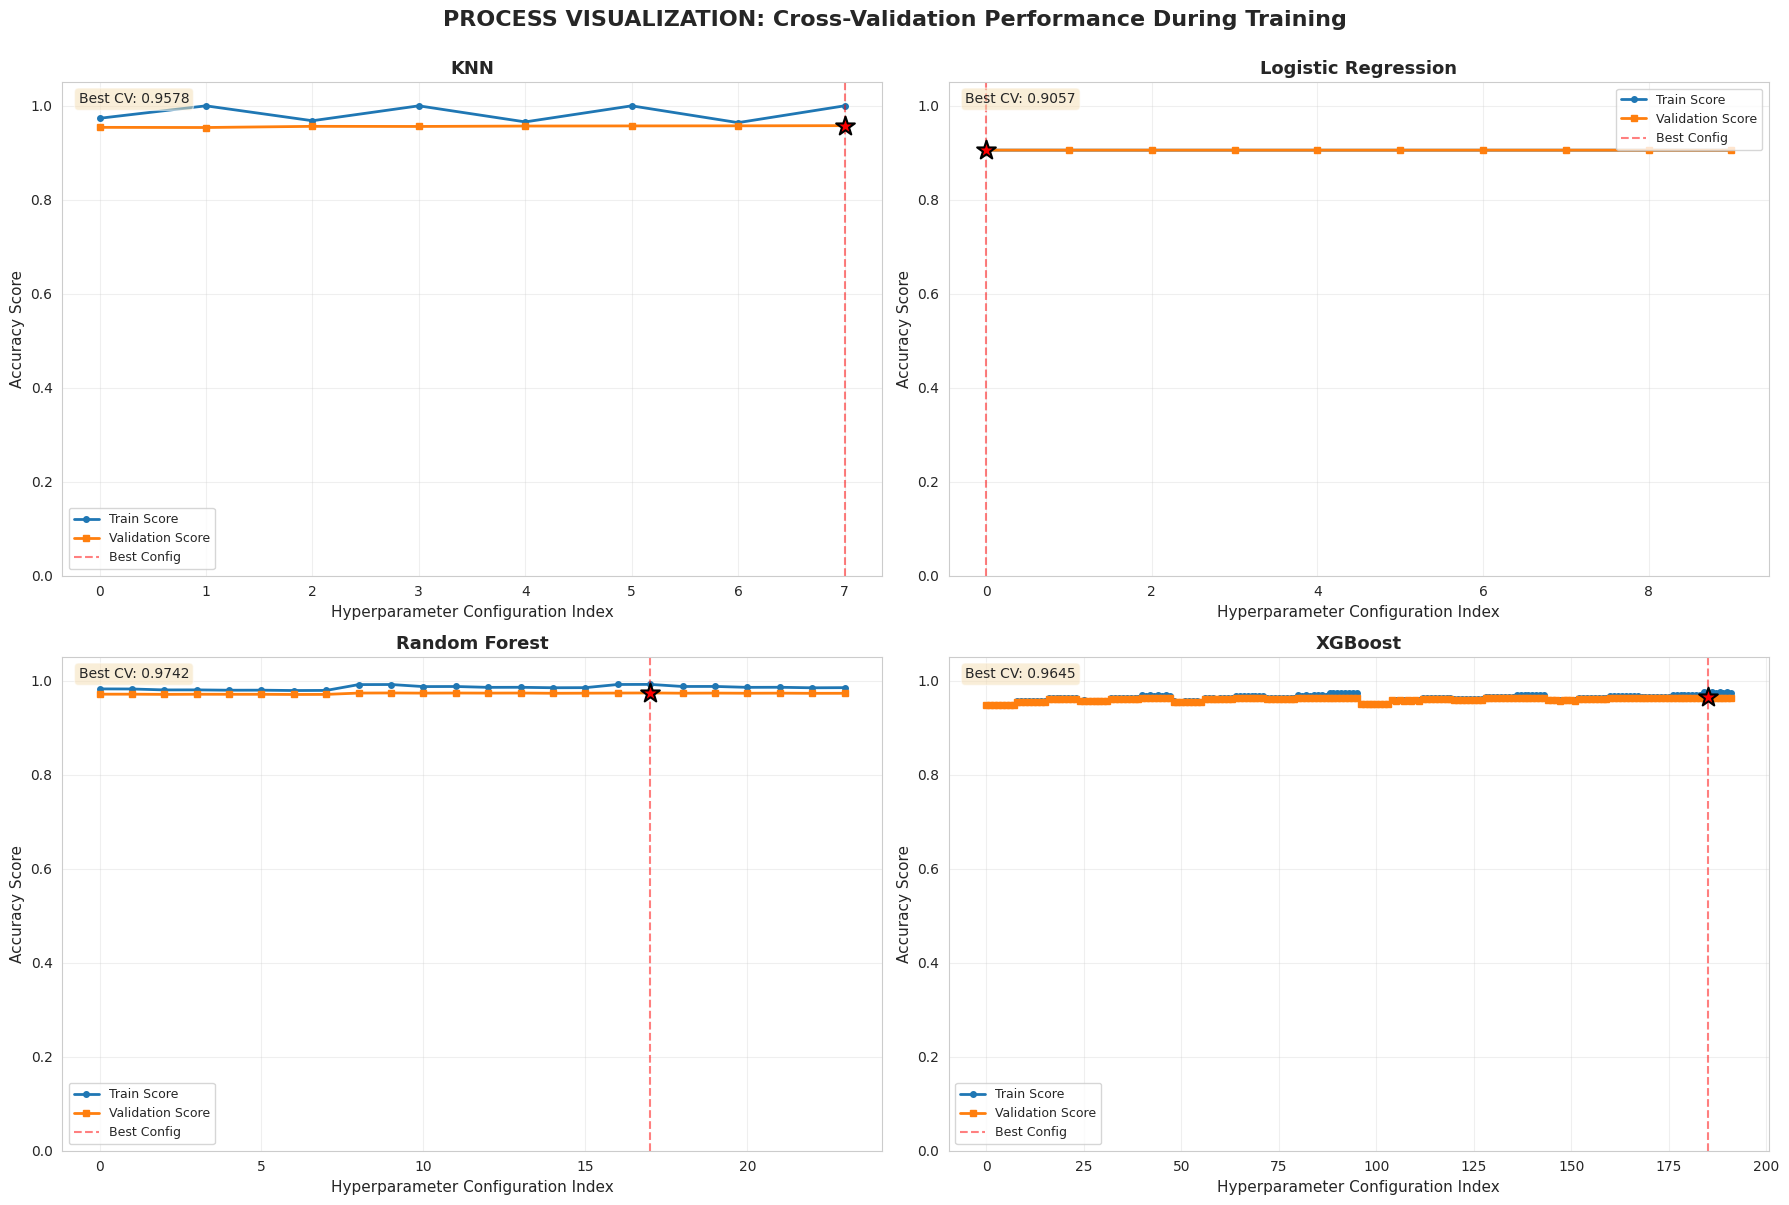

✓ Process Visualization: CV Performance saved as 'process_cv_performance.png'


In [13]:
# ============================================================================
# PROCESS VISUALIZATIONS: Model Training Process
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('PROCESS VISUALIZATION: Cross-Validation Performance During Training',
             fontsize=16, fontweight='bold', y=1.00)

for idx, (name, cv_results) in enumerate(training_history.items()):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]

    # Extract mean train and test scores
    mean_train_scores = cv_results['mean_train_score']
    mean_test_scores = cv_results['mean_test_score']
    std_test_scores = cv_results['std_test_score']

    # Create x-axis for parameter combinations
    x = np.arange(len(mean_train_scores))

    # Plot training and validation scores
    ax.plot(x, mean_train_scores, 'o-', label='Train Score', linewidth=2, markersize=4)
    ax.plot(x, mean_test_scores, 's-', label='Validation Score', linewidth=2, markersize=4)
    ax.fill_between(x,
                     mean_test_scores - std_test_scores,
                     mean_test_scores + std_test_scores,
                     alpha=0.2)

    # Highlight best score
    best_idx = cv_results['rank_test_score'].argmin()
    ax.axvline(x=best_idx, color='red', linestyle='--', alpha=0.5, label='Best Config')
    ax.scatter(best_idx, mean_test_scores.iloc[best_idx], color='red', s=200,
              marker='*', zorder=5, edgecolors='black', linewidth=1.5)

    ax.set_title(f'{name}', fontsize=13, fontweight='bold')
    ax.set_xlabel('Hyperparameter Configuration Index', fontsize=11)
    ax.set_ylabel('Accuracy Score', fontsize=11)
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1.05])

    # Add text box with best score
    textstr = f'Best CV: {cv_results["mean_test_score"].max():.4f}'
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('process_cv_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Process Visualization: CV Performance saved as 'process_cv_performance.png'")

Computing learning curve for KNN...
Computing learning curve for Logistic Regression...
Computing learning curve for Random Forest...
Computing learning curve for XGBoost...

✓ Learning curves computed for all models


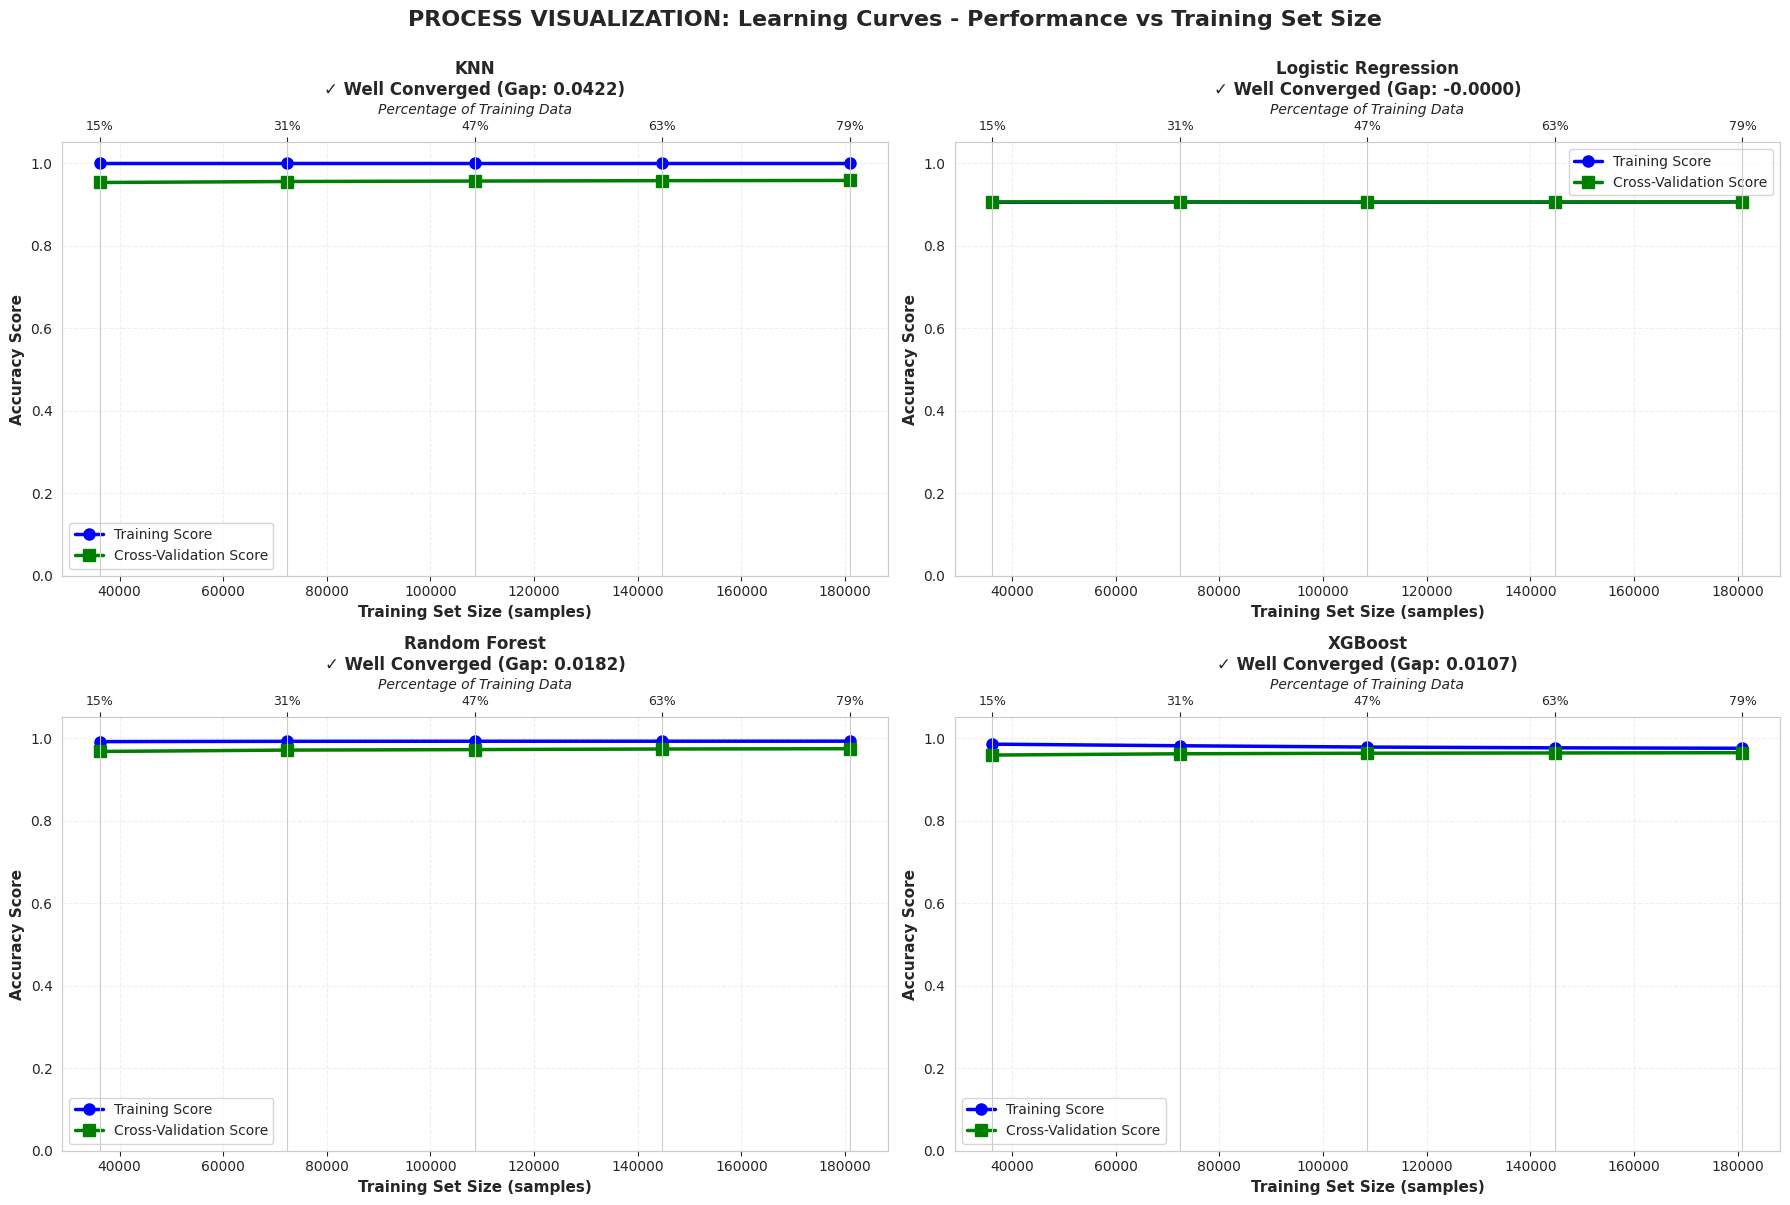

✓ Process Visualization: Learning Curves saved as 'process_learning_curves.png'


In [14]:
# ============================================================================
# PROCESS VISUALIZATION: True Learning Curves (Performance vs Training Size)
# ============================================================================

from sklearn.model_selection import learning_curve

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('PROCESS VISUALIZATION: Learning Curves - Performance vs Training Set Size',
             fontsize=16, fontweight='bold', y=1.00)

# Define training set sizes to evaluate (20%, 40%, 60%, 80%, 100%)
train_sizes = np.linspace(0.2, 1.0, 5)

for idx, (name, model_obj) in enumerate(best_models.items()):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]

    print(f"Computing learning curve for {name}...")

    # Calculate learning curve
    train_sizes_abs, train_scores, val_scores = learning_curve(
        model_obj, X_train_scaled, y_train,
        train_sizes=train_sizes,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        random_state=42
    )

    # Calculate mean and std
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plot learning curves
    ax.plot(train_sizes_abs, train_mean, 'o-', color='blue',
            label='Training Score', linewidth=2.5, markersize=8)
    ax.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std,
                     alpha=0.15, color='blue')

    ax.plot(train_sizes_abs, val_mean, 's-', color='green',
            label='Cross-Validation Score', linewidth=2.5, markersize=8)
    ax.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std,
                     alpha=0.15, color='green')

    # Calculate final gap
    final_gap = train_mean[-1] - val_mean[-1]

    # Add convergence indicator
    if final_gap < 0.05:
        convergence_text = "✓ Well Converged"
        text_color = 'green'
    elif final_gap < 0.10:
        convergence_text = "⚠ Moderate Gap"
        text_color = 'orange'
    else:
        convergence_text = "⚠ High Variance"
        text_color = 'red'

    ax.set_title(f'{name}\n{convergence_text} (Gap: {final_gap:.4f})',
                fontsize=12, fontweight='bold')
    ax.set_xlabel('Training Set Size (samples)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Accuracy Score', fontsize=11, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_ylim([0, 1.05])

    # Add percentage labels on x-axis
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(train_sizes_abs)
    ax2.set_xticklabels([f'{int(s/len(y_train)*100)}%' for s in train_sizes_abs], fontsize=9)
    ax2.set_xlabel('Percentage of Training Data', fontsize=10, style='italic')

print("\n✓ Learning curves computed for all models")

plt.tight_layout()
plt.savefig('process_learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Process Visualization: Learning Curves saved as 'process_learning_curves.png'")

## 9. Result Visualizations (Best Model)

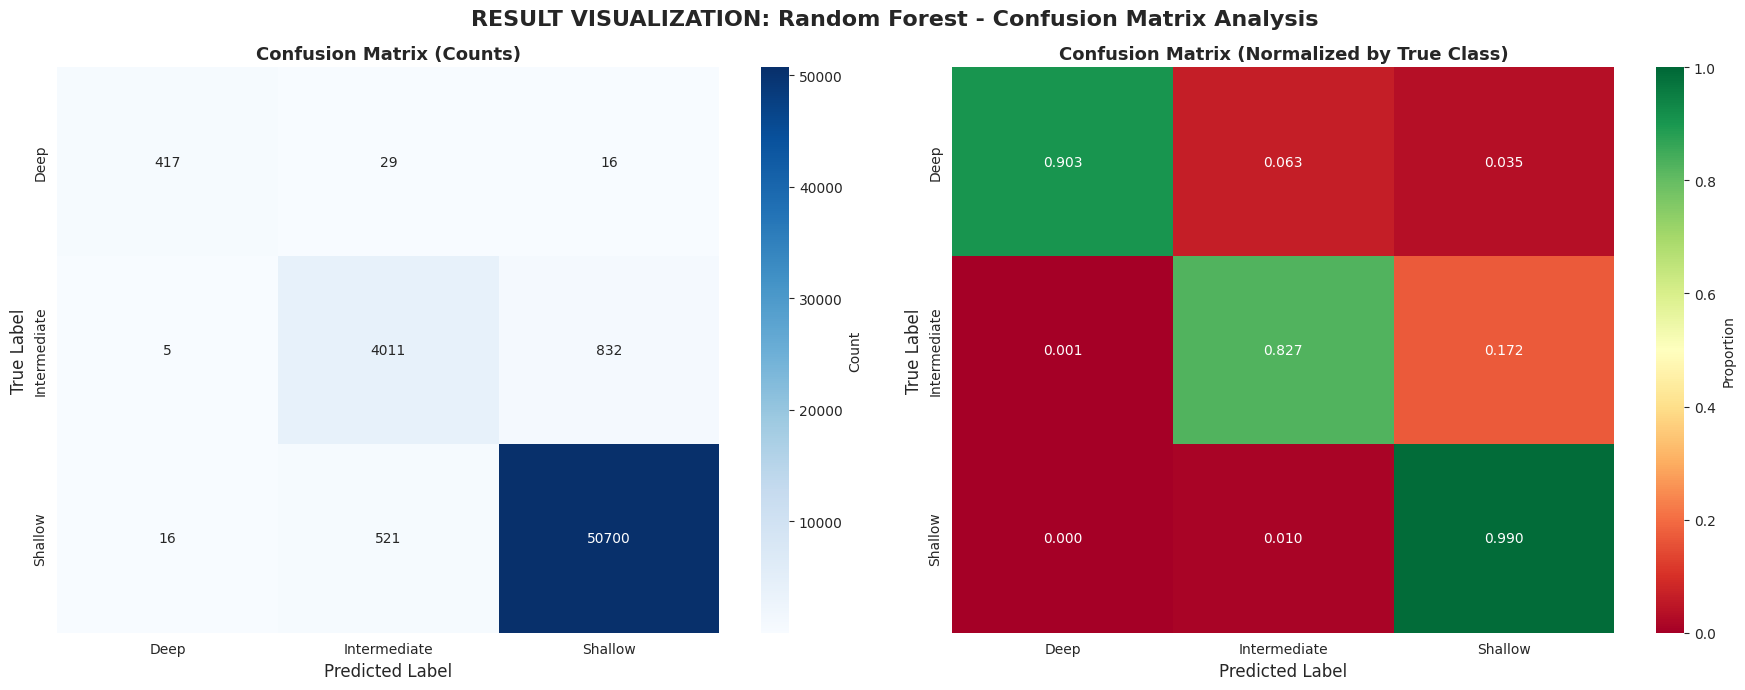


DETAILED CLASSIFICATION REPORT - Random Forest
              precision    recall  f1-score   support

        Deep       0.95      0.90      0.93       462
Intermediate       0.88      0.83      0.85      4848
     Shallow       0.98      0.99      0.99     51237

    accuracy                           0.97     56547
   macro avg       0.94      0.91      0.92     56547
weighted avg       0.97      0.97      0.97     56547


Per-Class Performance Analysis:
  Deep           :   417/  462 correct ( 90.26%)
  Intermediate   :  4011/ 4848 correct ( 82.74%)
  Shallow        : 50700/51237 correct ( 98.95%)

✓ Result Visualization: Confusion Matrix saved
   File: result_confusion_matrix_Random_Forest.png


In [15]:
# ============================================================================
# RESULT VISUALIZATION (BEST MODEL): Confusion Matrix
# ============================================================================

# Get best model results
best_model_name = metrics_df.iloc[0]['Model']
best_cm = results[best_model_name]['confusion_matrix']

# Create detailed confusion matrix visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle(f'RESULT VISUALIZATION: {best_model_name} - Confusion Matrix Analysis',
             fontsize=16, fontweight='bold')

# Plot 1: Raw counts
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix (Counts)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Plot 2: Normalized by true label (recall perspective)
cm_normalized = best_cm.astype('float') / best_cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='RdYlGn',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            ax=axes[1], cbar_kws={'label': 'Proportion'}, vmin=0, vmax=1)
axes[1].set_title('Confusion Matrix (Normalized by True Class)', fontsize=13, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.savefig(f'result_confusion_matrix_{best_model_name.replace(" ", "_")}.png',
            dpi=300, bbox_inches='tight')
plt.show()

# Print detailed classification report
print("\n" + "="*70)
print(f"DETAILED CLASSIFICATION REPORT - {best_model_name}")
print("="*70)
print(results[best_model_name]['classification_report'])
print("="*70)

# Calculate and display per-class metrics
print("\nPer-Class Performance Analysis:")
for i, class_name in enumerate(label_encoder.classes_):
    total = best_cm[i].sum()
    correct = best_cm[i, i]
    accuracy = correct / total if total > 0 else 0
    print(f"  {class_name:15s}: {correct:5d}/{total:5d} correct ({accuracy*100:6.2f}%)")

print(f"\n✓ Result Visualization: Confusion Matrix saved")
print(f"   File: result_confusion_matrix_{best_model_name.replace(' ', '_')}.png")

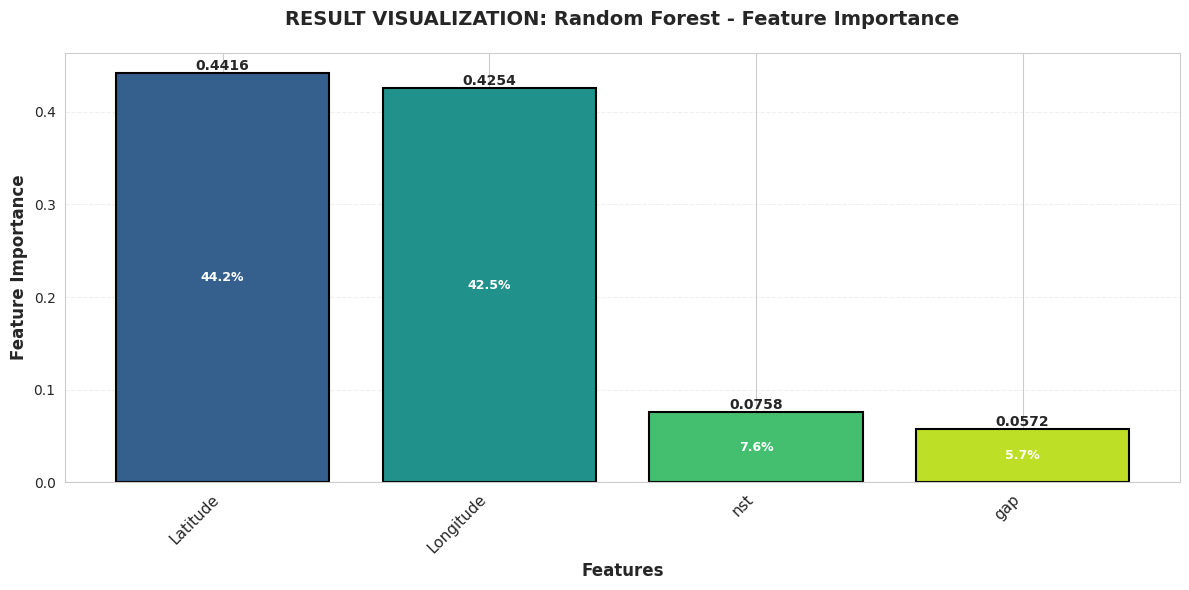


FEATURE IMPORTANCE RANKING - Random Forest
1. Latitude       : 0.441647 (44.16%)
2. Longitude      : 0.425441 (42.54%)
3. nst            : 0.075751 ( 7.58%)
4. gap            : 0.057161 ( 5.72%)

✓ Result Visualization: Feature Importance saved
   File: result_feature_importance_Random_Forest.png


In [16]:
# ============================================================================
# RESULT VISUALIZATION (BEST MODEL): Feature Importance
# ============================================================================

best_model_obj = best_models[best_model_name]

# Extract feature importance based on model type
if hasattr(best_model_obj, 'feature_importances_'):
    # Random Forest or XGBoost
    importances = best_model_obj.feature_importances_
    importance_type = 'Feature Importance'
elif hasattr(best_model_obj, 'coef_'):
    # Logistic Regression
    # For multi-class, use average absolute coefficient
    importances = np.abs(best_model_obj.coef_).mean(axis=0)
    importance_type = 'Average Absolute Coefficient'
else:
    # KNN doesn't have feature importance, use permutation importance or correlation
    from sklearn.inspection import permutation_importance
    perm_importance = permutation_importance(best_model_obj, X_test_scaled, y_test,
                                            n_repeats=10, random_state=42, n_jobs=-1)
    importances = perm_importance.importances_mean
    importance_type = 'Permutation Importance'

# Create feature importance visualization
fig, ax = plt.subplots(figsize=(12, 6))

# Sort features by importance
indices = np.argsort(importances)[::-1]
sorted_features = [features[i] for i in indices]
sorted_importances = importances[indices]

# Create bar plot
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(sorted_features)))
bars = ax.bar(range(len(sorted_features)), sorted_importances, color=colors,
              edgecolor='black', linewidth=1.5)

# Customize plot
ax.set_title(f'RESULT VISUALIZATION: {best_model_name} - {importance_type}',
            fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Features', fontsize=12, fontweight='bold')
ax.set_ylabel(importance_type, fontsize=12, fontweight='bold')
ax.set_xticks(range(len(sorted_features)))
ax.set_xticklabels(sorted_features, rotation=45, ha='right', fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, sorted_importances)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.4f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add percentage contribution
total_importance = sorted_importances.sum()
for i, (bar, val) in enumerate(zip(bars, sorted_importances)):
    pct = (val / total_importance * 100) if total_importance > 0 else 0
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height()/2,
            f'{pct:.1f}%',
            ha='center', va='center', fontsize=9, color='white', fontweight='bold')

plt.tight_layout()
plt.savefig(f'result_feature_importance_{best_model_name.replace(" ", "_")}.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print(f"FEATURE IMPORTANCE RANKING - {best_model_name}")
print("="*70)
for i, (feat, imp) in enumerate(zip(sorted_features, sorted_importances), 1):
    pct = (imp / total_importance * 100) if total_importance > 0 else 0
    print(f"{i}. {feat:15s}: {imp:.6f} ({pct:5.2f}%)")
print("="*70)

print(f"\n✓ Result Visualization: Feature Importance saved")
print(f"   File: result_feature_importance_{best_model_name.replace(' ', '_')}.png")

## 10. Comparison Visualizations

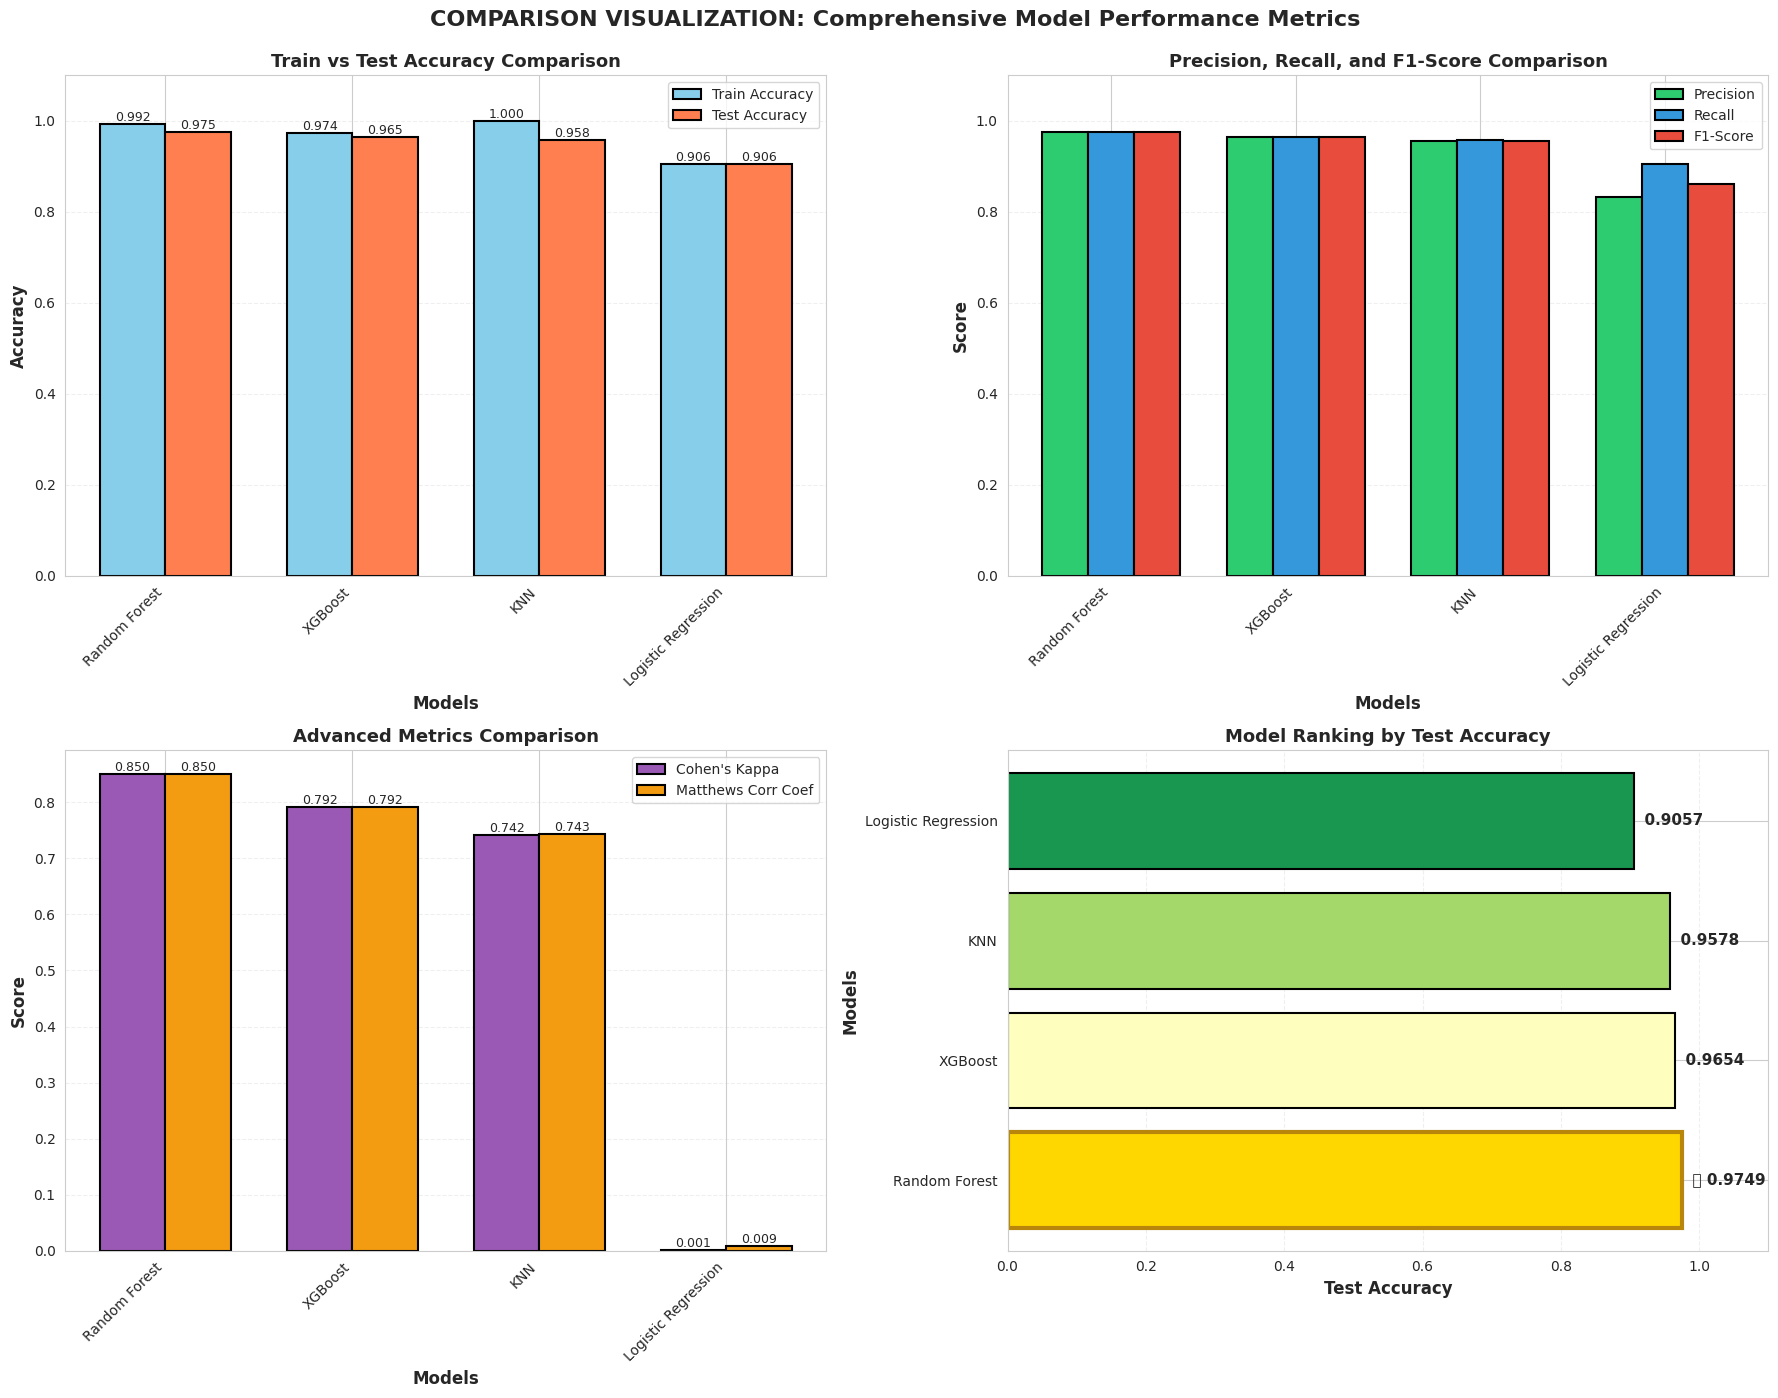

✓ Comparison Visualization: Model Performance saved as 'comparison_model_performance.png'


In [17]:
# ============================================================================
# COMPARISON VISUALIZATION: Model Performance Comparison
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('COMPARISON VISUALIZATION: Comprehensive Model Performance Metrics',
             fontsize=16, fontweight='bold', y=0.995)

# Plot 1: Accuracy Comparison (Train vs Test)
ax1 = axes[0, 0]
x_pos = np.arange(len(metrics_df))
width = 0.35

bars1 = ax1.bar(x_pos - width/2, metrics_df['Train Accuracy'], width,
                label='Train Accuracy', color='skyblue', edgecolor='black', linewidth=1.5)
bars2 = ax1.bar(x_pos + width/2, metrics_df['Test Accuracy'], width,
                label='Test Accuracy', color='coral', edgecolor='black', linewidth=1.5)

ax1.set_xlabel('Models', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Train vs Test Accuracy Comparison', fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(metrics_df['Model'], rotation=45, ha='right')
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_ylim([0, 1.1])

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Plot 2: Precision, Recall, F1-Score Comparison
ax2 = axes[0, 1]
width = 0.25
x_pos = np.arange(len(metrics_df))

bars1 = ax2.bar(x_pos - width, metrics_df['Precision'], width,
                label='Precision', color='#2ecc71', edgecolor='black', linewidth=1.5)
bars2 = ax2.bar(x_pos, metrics_df['Recall'], width,
                label='Recall', color='#3498db', edgecolor='black', linewidth=1.5)
bars3 = ax2.bar(x_pos + width, metrics_df['F1-Score'], width,
                label='F1-Score', color='#e74c3c', edgecolor='black', linewidth=1.5)

ax2.set_xlabel('Models', fontsize=12, fontweight='bold')
ax2.set_ylabel('Score', fontsize=12, fontweight='bold')
ax2.set_title('Precision, Recall, and F1-Score Comparison', fontsize=13, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(metrics_df['Model'], rotation=45, ha='right')
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_ylim([0, 1.1])

# Plot 3: Cohen's Kappa and MCC
ax3 = axes[1, 0]
x_pos = np.arange(len(metrics_df))
width = 0.35

bars1 = ax3.bar(x_pos - width/2, metrics_df['Cohen Kappa'], width,
                label="Cohen's Kappa", color='#9b59b6', edgecolor='black', linewidth=1.5)
bars2 = ax3.bar(x_pos + width/2, metrics_df['MCC'], width,
                label='Matthews Corr Coef', color='#f39c12', edgecolor='black', linewidth=1.5)

ax3.set_xlabel('Models', fontsize=12, fontweight='bold')
ax3.set_ylabel('Score', fontsize=12, fontweight='bold')
ax3.set_title('Advanced Metrics Comparison', fontsize=13, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(metrics_df['Model'], rotation=45, ha='right')
ax3.legend(fontsize=10)
ax3.grid(axis='y', alpha=0.3, linestyle='--')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height == height:  # Check for NaN
            ax3.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom' if height >= 0 else 'top',
                    fontsize=9)

# Plot 4: Overall Model Ranking (Test Accuracy)
ax4 = axes[1, 1]
colors_ranked = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(metrics_df)))
bars = ax4.barh(metrics_df['Model'], metrics_df['Test Accuracy'],
                color=colors_ranked, edgecolor='black', linewidth=1.5)

# Highlight best model
bars[0].set_color('gold')
bars[0].set_edgecolor('darkgoldenrod')
bars[0].set_linewidth(3)

ax4.set_xlabel('Test Accuracy', fontsize=12, fontweight='bold')
ax4.set_ylabel('Models', fontsize=12, fontweight='bold')
ax4.set_title('Model Ranking by Test Accuracy', fontsize=13, fontweight='bold')
ax4.grid(axis='x', alpha=0.3, linestyle='--')
ax4.set_xlim([0, 1.1])

# Add value labels and ranking
for i, (bar, model) in enumerate(zip(bars, metrics_df['Model'])):
    width_val = bar.get_width()
    rank = i + 1
    label = f'{width_val:.4f}'
    if rank == 1:
        label = f'🏆 {label}'
    ax4.text(width_val, bar.get_y() + bar.get_height()/2.,
            f'  {label}', ha='left', va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('comparison_model_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Comparison Visualization: Model Performance saved as 'comparison_model_performance.png'")

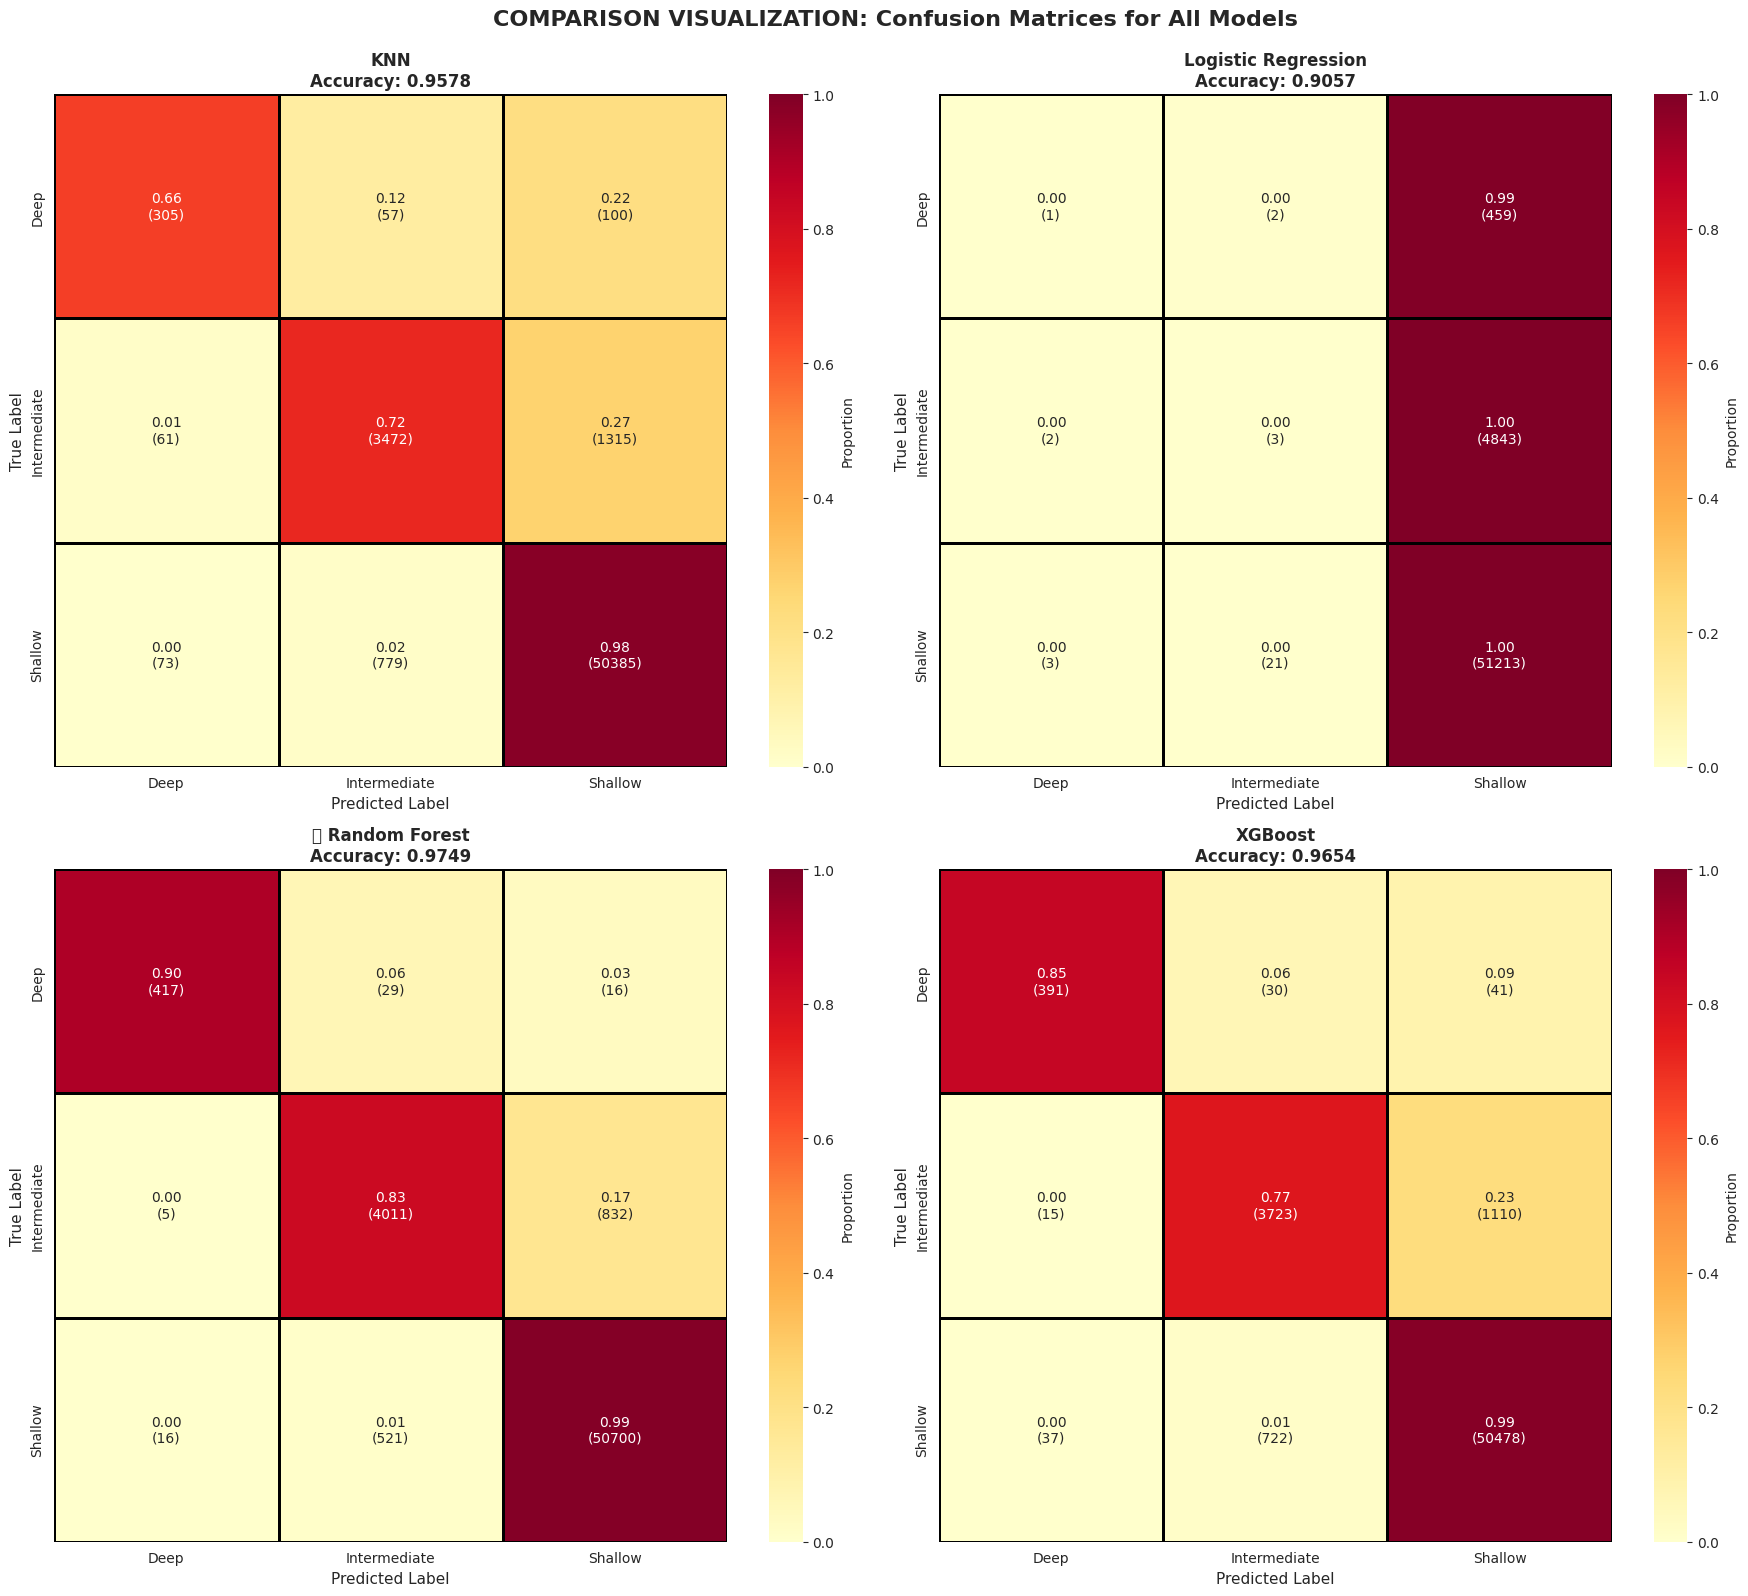

✓ Comparison Visualization: All Confusion Matrices saved as 'comparison_all_confusion_matrices.png'


In [18]:
# ============================================================================
# COMPARISON VISUALIZATION: All Models Confusion Matrices
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(18, 16))
fig.suptitle('COMPARISON VISUALIZATION: Confusion Matrices for All Models',
             fontsize=16, fontweight='bold', y=0.995)

for idx, (name, result) in enumerate(results.items()):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]

    cm = result['confusion_matrix']
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot normalized confusion matrix
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='YlOrRd',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_,
                ax=ax, cbar_kws={'label': 'Proportion'}, vmin=0, vmax=1,
                linewidths=1, linecolor='black')

    # Add counts in parentheses
    for i in range(len(label_encoder.classes_)):
        for j in range(len(label_encoder.classes_)):
            text = ax.texts[i * len(label_encoder.classes_) + j]
            count = cm[i, j]
            text.set_text(f'{cm_normalized[i, j]:.2f}\n({count})')

    accuracy = result['test_accuracy']
    title = f'{name}\nAccuracy: {accuracy:.4f}'
    if name == best_model_name:
        title = f'🏆 {title}'
        ax.set_facecolor('#fffacd')  # Light yellow background for best model

    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=11)
    ax.set_xlabel('Predicted Label', fontsize=11)

plt.tight_layout()
plt.savefig('comparison_all_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Comparison Visualization: All Confusion Matrices saved as 'comparison_all_confusion_matrices.png'")

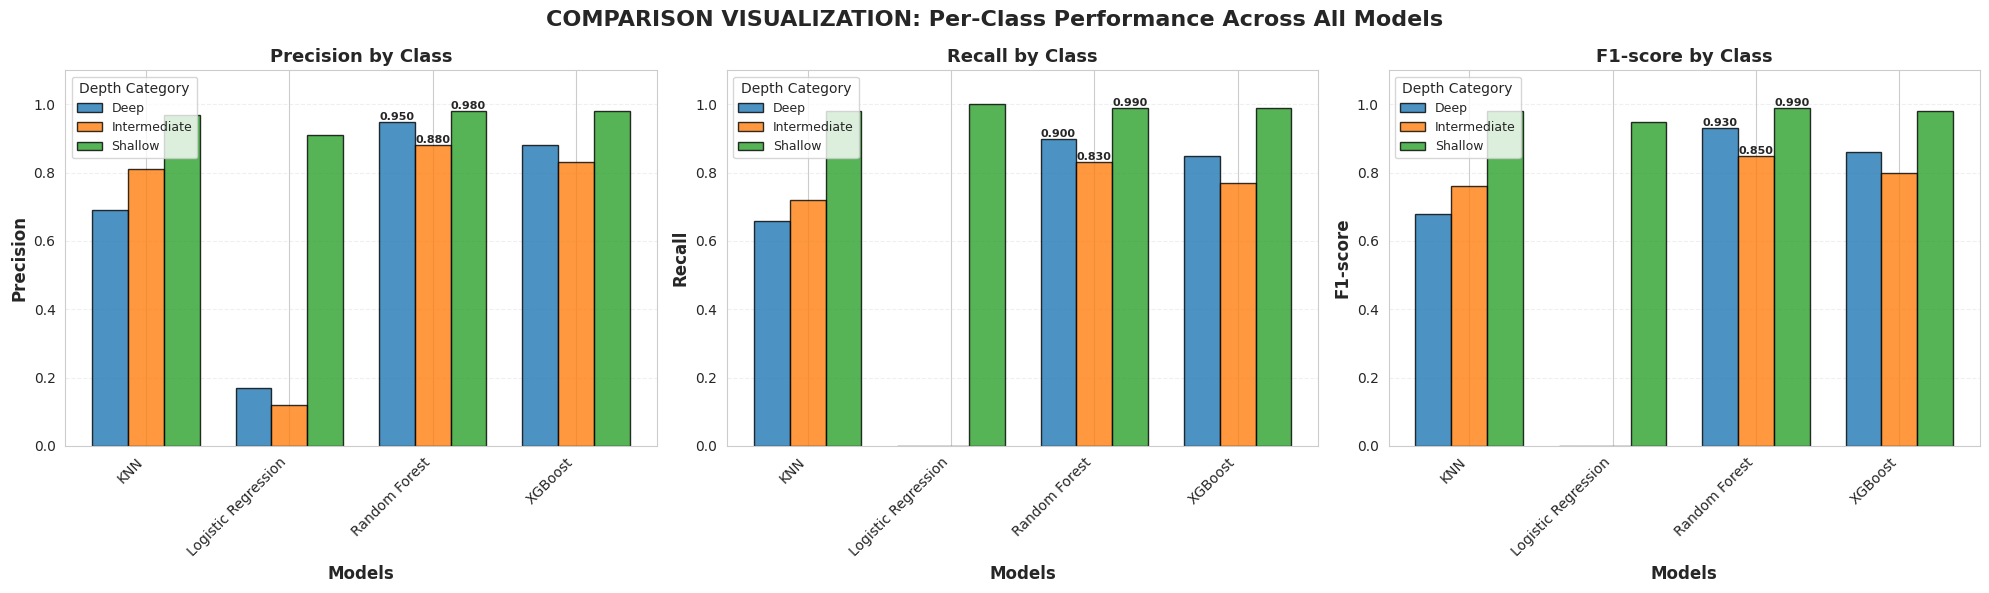

✓ Comparison Visualization: Per-Class Performance saved as 'comparison_per_class_performance.png'


In [19]:
# ============================================================================
# COMPARISON VISUALIZATION: Per-Class Performance Across Models
# ============================================================================

# Extract per-class metrics for all models
class_metrics = {class_name: {'precision': [], 'recall': [], 'f1-score': []}
                 for class_name in label_encoder.classes_}
model_names_list = list(results.keys())

for model_name in model_names_list:
    report = results[model_name]['classification_report']
    lines = report.strip().split('\n')

    # Parse classification report
    for line in lines[2:-4]:  # Skip header and footer lines
        parts = line.split()
        if len(parts) >= 4 and parts[0] in label_encoder.classes_:
            class_name = parts[0]
            precision = float(parts[1])
            recall = float(parts[2])
            f1 = float(parts[3])

            class_metrics[class_name]['precision'].append(precision)
            class_metrics[class_name]['recall'].append(recall)
            class_metrics[class_name]['f1-score'].append(f1)

# Create comparison plots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('COMPARISON VISUALIZATION: Per-Class Performance Across All Models',
             fontsize=16, fontweight='bold')

metrics_to_plot = ['precision', 'recall', 'f1-score']
colors = ['#3498db', '#2ecc71', '#e74c3c']

for idx, (metric, color) in enumerate(zip(metrics_to_plot, colors)):
    ax = axes[idx]

    x = np.arange(len(model_names_list))
    width = 0.25

    for i, class_name in enumerate(label_encoder.classes_):
        offset = (i - 1) * width
        values = class_metrics[class_name][metric]
        bars = ax.bar(x + offset, values, width, label=class_name,
                     edgecolor='black', linewidth=1, alpha=0.8)

        # Add value labels for best model
        for j, (bar, val) in enumerate(zip(bars, values)):
            if model_names_list[j] == best_model_name:
                ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                       f'{val:.3f}', ha='center', va='bottom', fontsize=8,
                       fontweight='bold')

    ax.set_xlabel('Models', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric.capitalize(), fontsize=12, fontweight='bold')
    ax.set_title(f'{metric.capitalize()} by Class', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names_list, rotation=45, ha='right')
    ax.legend(title='Depth Category', fontsize=9, title_fontsize=10)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim([0, 1.1])

plt.tight_layout()
plt.savefig('comparison_per_class_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Comparison Visualization: Per-Class Performance saved as 'comparison_per_class_performance.png'")

## 11. Final Summary and Recommendations

In [20]:
# ============================================================================
# FINAL SUMMARY AND RECOMMENDATIONS
# ============================================================================

print("\n" + "="*100)
print(" " * 35 + "FINAL SUMMARY REPORT")
print("="*100)

print("\n📊 DATASET SUMMARY:")
print(f"   • Total samples: {len(df_clean):,}")
print(f"   • Features used: {', '.join(features)}")
print(f"   • Target classes: {', '.join(label_encoder.classes_)}")
print(f"   • Train/Test split: 80/20")

print("\n🏆 BEST MODEL:")
print(f"   • Model: {best_model_name}")
print(f"   • Test Accuracy: {metrics_df.iloc[0]['Test Accuracy']:.4f}")
print(f"   • F1-Score: {metrics_df.iloc[0]['F1-Score']:.4f}")
print(f"   • Precision: {metrics_df.iloc[0]['Precision']:.4f}")
print(f"   • Recall: {metrics_df.iloc[0]['Recall']:.4f}")
print(f"   • Cohen's Kappa: {metrics_df.iloc[0]['Cohen Kappa']:.4f}")
print(f"   • Best Parameters: {results[best_model_name]['best_params']}")

print("\n📈 MODEL RANKINGS (by Test Accuracy):")
for i, row in metrics_df.iterrows():
    medal = "🥇" if i == 0 else "🥈" if i == 1 else "🥉" if i == 2 else "  "
    print(f"   {medal} {i+1}. {row['Model']:20s} - Accuracy: {row['Test Accuracy']:.4f}, F1: {row['F1-Score']:.4f}")

print("\n🎯 KEY INSIGHTS:")
# Calculate overfitting
train_test_gap = metrics_df['Train Accuracy'] - metrics_df['Test Accuracy']
most_overfit = metrics_df.loc[train_test_gap.idxmax(), 'Model']
least_overfit = metrics_df.loc[train_test_gap.idxmin(), 'Model']

print(f"   • Most generalizable model: {least_overfit} (smallest train-test gap)")
print(f"   • Highest train-test gap: {most_overfit} ({train_test_gap.max():.4f})")

# Analyze class performance for best model
best_report_lines = results[best_model_name]['classification_report'].strip().split('\n')
print(f"\n   • Best performing class for {best_model_name}:")
max_f1 = 0
best_class = ""
for line in best_report_lines[2:-4]:
    parts = line.split()
    if len(parts) >= 4 and parts[0] in label_encoder.classes_:
        f1 = float(parts[3])
        if f1 > max_f1:
            max_f1 = f1
            best_class = parts[0]
print(f"     → {best_class} (F1-Score: {max_f1:.4f})")

print("\n📁 GENERATED VISUALIZATIONS:")
print("   1. process_cv_performance.png - Cross-validation performance during training")
print("   2. process_learning_curves.png - Train vs validation accuracy curves")
print(f"   3. result_confusion_matrix_{best_model_name.replace(' ', '_')}.png - Best model confusion matrix")
print(f"   4. result_feature_importance_{best_model_name.replace(' ', '_')}.png - Feature importance analysis")
print("   5. comparison_model_performance.png - Comprehensive model comparison")
print("   6. comparison_all_confusion_matrices.png - All models confusion matrices")
print("   7. comparison_per_class_performance.png - Per-class metrics comparison")

print("\n💡 RECOMMENDATIONS:")
if best_model_name in ['Random Forest', 'XGBoost']:
    print(f"   • {best_model_name} performs best for this task")
    print("   • Consider ensemble methods for production deployment")
    print("   • Monitor feature importance for feature engineering opportunities")
elif best_model_name == 'Logistic Regression':
    print("   • Logistic Regression provides good interpretability")
    print("   • Consider feature engineering to improve performance")
elif best_model_name == 'KNN':
    print("   • KNN is performing well but may be slow on large datasets")
    print("   • Consider dimensionality reduction for scaling")

print("\n   • Check confusion matrix for class-specific performance")
print("   • Consider using the best model for earthquake depth prediction")
print("   • Evaluate model on new data before deployment")

print("\n" + "="*100)
print(" " * 30 + "ANALYSIS COMPLETE!")
print("="*100)


                                   FINAL SUMMARY REPORT

📊 DATASET SUMMARY:
   • Total samples: 282,734
   • Features used: Latitude, Longitude, nst, gap
   • Target classes: Deep, Intermediate, Shallow
   • Train/Test split: 80/20

🏆 BEST MODEL:
   • Model: Random Forest
   • Test Accuracy: 0.9749
   • F1-Score: 0.9746
   • Precision: 0.9744
   • Recall: 0.9749
   • Cohen's Kappa: 0.8498
   • Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

📈 MODEL RANKINGS (by Test Accuracy):
   🥇 1. Random Forest        - Accuracy: 0.9749, F1: 0.9746
   🥈 2. XGBoost              - Accuracy: 0.9654, F1: 0.9648
   🥉 3. KNN                  - Accuracy: 0.9578, F1: 0.9567
      4. Logistic Regression  - Accuracy: 0.9057, F1: 0.8614

🎯 KEY INSIGHTS:
   • Most generalizable model: Logistic Regression (smallest train-test gap)
   • Highest train-test gap: KNN (0.0422)

   • Best performing class for Random Forest:
     → Shallow (F1-Score: 0.9900)



## 12. Save Results, Models, and Outputs

In [21]:
# ============================================================================
# SAVE ALL RESULTS, MODELS, AND OUTPUTS
# ============================================================================

import json
import pickle
from datetime import datetime
import os

# Create output directory
output_dir = 'earthquake_model_outputs'
os.makedirs(output_dir, exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

print("\n" + "="*100)
print(" " * 35 + "SAVING ALL OUTPUTS")
print("="*100)

# ============================================================================
# 1. Save Results Dictionary as JSON
# ============================================================================
print("\n📄 Saving results to JSON...")

# Prepare results for JSON serialization (convert numpy arrays to lists)
results_serializable = {}
for model_name, model_results in results.items():
    results_serializable[model_name] = {
        'best_params': model_results['best_params'],
        'best_cv_score': float(model_results['best_cv_score']),
        'train_accuracy': float(model_results['train_accuracy']),
        'test_accuracy': float(model_results['test_accuracy']),
        'test_precision': float(model_results['test_precision']),
        'test_recall': float(model_results['test_recall']),
        'test_f1': float(model_results['test_f1']),
        'test_kappa': float(model_results['test_kappa']) if model_results['test_kappa'] is not None else None,
        'test_mcc': float(model_results['test_mcc']) if model_results['test_mcc'] is not None else None,
        'confusion_matrix': model_results['confusion_matrix'].tolist(),
        'test_predictions': model_results['test_predictions'].tolist(),
        'classification_report': model_results['classification_report']
    }

# Add metadata
output_data = {
    'metadata': {
        'timestamp': timestamp,
        'dataset_shape': df_clean.shape,
        'features': features,
        'target': target,
        'classes': label_encoder.classes_.tolist(),
        'train_size': X_train.shape[0],
        'test_size': X_test.shape[0],
        'best_model': best_model_name
    },
    'model_results': results_serializable,
    'metrics_summary': metrics_df.to_dict(orient='records')
}

json_path = os.path.join(output_dir, f'results_{timestamp}.json')
with open(json_path, 'w') as f:
    json.dump(output_data, f, indent=2)

print(f"   ✓ Results saved to: {json_path}")

# ============================================================================
# 2. Save Trained Models
# ============================================================================
print("\n🤖 Saving trained models...")

models_dir = os.path.join(output_dir, 'models')
os.makedirs(models_dir, exist_ok=True)

for model_name, model_obj in best_models.items():
    model_filename = f"{model_name.replace(' ', '_').lower()}_{timestamp}.pkl"
    model_path = os.path.join(models_dir, model_filename)

    with open(model_path, 'wb') as f:
        pickle.dump(model_obj, f)

    print(f"   ✓ {model_name} saved to: {model_path}")

# ============================================================================
# 3. Save Scaler and Label Encoder
# ============================================================================
print("\n🔧 Saving preprocessing objects...")

scaler_path = os.path.join(models_dir, f'scaler_{timestamp}.pkl')
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"   ✓ Scaler saved to: {scaler_path}")

encoder_path = os.path.join(models_dir, f'label_encoder_{timestamp}.pkl')
with open(encoder_path, 'wb') as f:
    pickle.dump(label_encoder, f)
print(f"   ✓ Label encoder saved to: {encoder_path}")

# ============================================================================
# 4. Save Best Model Package (for easy deployment)
# ============================================================================
print("\n📦 Saving best model deployment package...")

best_model_package = {
    'model': best_models[best_model_name],
    'scaler': scaler,
    'label_encoder': label_encoder,
    'features': features,
    'model_name': best_model_name,
    'best_params': results[best_model_name]['best_params'],
    'test_accuracy': results[best_model_name]['test_accuracy'],
    'metadata': {
        'timestamp': timestamp,
        'classes': label_encoder.classes_.tolist()
    }
}

best_model_path = os.path.join(output_dir, f'best_model_package_{timestamp}.pkl')
with open(best_model_path, 'wb') as f:
    pickle.dump(best_model_package, f)

print(f"   ✓ Best model package saved to: {best_model_path}")

# ============================================================================
# 5. Save Metrics Summary as CSV
# ============================================================================
print("\n📊 Saving metrics summary...")

csv_path = os.path.join(output_dir, f'metrics_summary_{timestamp}.csv')
metrics_df.to_csv(csv_path, index=False)
print(f"   ✓ Metrics CSV saved to: {csv_path}")

# ============================================================================
# 6. Save Detailed Text Report
# ============================================================================
print("\n📝 Saving detailed text report...")

report_path = os.path.join(output_dir, f'detailed_report_{timestamp}.txt')
with open(report_path, 'w') as f:
    f.write("="*100 + "\n")
    f.write(" " * 35 + "EARTHQUAKE DEPTH PREDICTION - DETAILED REPORT\n")
    f.write("="*100 + "\n\n")

    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")

    f.write("DATASET SUMMARY:\n")
    f.write(f"   • Total samples: {len(df_clean):,}\n")
    f.write(f"   • Features used: {', '.join(features)}\n")
    f.write(f"   • Target classes: {', '.join(label_encoder.classes_)}\n")
    f.write(f"   • Train/Test split: 80/20 ({X_train.shape[0]}/{X_test.shape[0]})\n\n")

    f.write("BEST MODEL:\n")
    f.write(f"   • Model: {best_model_name}\n")
    f.write(f"   • Test Accuracy: {metrics_df.iloc[0]['Test Accuracy']:.4f}\n")
    f.write(f"   • F1-Score: {metrics_df.iloc[0]['F1-Score']:.4f}\n")
    f.write(f"   • Precision: {metrics_df.iloc[0]['Precision']:.4f}\n")
    f.write(f"   • Recall: {metrics_df.iloc[0]['Recall']:.4f}\n")
    f.write(f"   • Cohen's Kappa: {metrics_df.iloc[0]['Cohen Kappa']:.4f}\n")
    f.write(f"   • Best Parameters: {results[best_model_name]['best_params']}\n\n")

    f.write("MODEL RANKINGS (by Test Accuracy):\n")
    for i, row in metrics_df.iterrows():
        f.write(f"   {i+1}. {row['Model']:20s} - Accuracy: {row['Test Accuracy']:.4f}, F1: {row['F1-Score']:.4f}\n")

    f.write("\n" + "="*100 + "\n")
    f.write("DETAILED CLASSIFICATION REPORTS:\n")
    f.write("="*100 + "\n\n")

    for model_name in results.keys():
        f.write(f"\n{model_name}:\n")
        f.write("-" * 80 + "\n")
        f.write(results[model_name]['classification_report'])
        f.write("\n")

print(f"   ✓ Detailed report saved to: {report_path}")

# ============================================================================
# 7. Save Training History (CV Results)
# ============================================================================
print("\n📈 Saving training history (CV results)...")

cv_dir = os.path.join(output_dir, 'cv_results')
os.makedirs(cv_dir, exist_ok=True)

for model_name, cv_results in training_history.items():
    cv_path = os.path.join(cv_dir, f"{model_name.replace(' ', '_').lower()}_cv_results_{timestamp}.csv")
    cv_results.to_csv(cv_path, index=False)
    print(f"   ✓ {model_name} CV results saved to: {cv_path}")

# ============================================================================
# 8. Move Visualization Files to Output Directory
# ============================================================================
print("\n🖼️  Organizing visualization files...")

viz_dir = os.path.join(output_dir, 'visualizations')
os.makedirs(viz_dir, exist_ok=True)

import shutil
import glob

# Find all PNG files in current directory
png_files = glob.glob('*.png')
for png_file in png_files:
    if any(prefix in png_file for prefix in ['process_', 'result_', 'comparison_']):
        dest_path = os.path.join(viz_dir, png_file)
        shutil.copy2(png_file, dest_path)
        print(f"   ✓ Copied {png_file} to visualizations folder")

# ============================================================================
# Summary
# ============================================================================
print("\n" + "="*100)
print(" " * 35 + "SAVE COMPLETE!")
print("="*100)

print(f"\n📁 All outputs saved to: {os.path.abspath(output_dir)}/")
print("\nSaved files:")
print(f"   • JSON results: {os.path.basename(json_path)}")
print(f"   • Best model package: {os.path.basename(best_model_path)}")
print(f"   • Metrics CSV: {os.path.basename(csv_path)}")
print(f"   • Detailed report: {os.path.basename(report_path)}")
print(f"   • Trained models: {len(best_models)} model files in models/")
print(f"   • CV results: {len(training_history)} CSV files in cv_results/")
print(f"   • Visualizations: {len(png_files)} PNG files in visualizations/")

print("\n💡 To load the best model later:")
print(f"   with open('{best_model_path}', 'rb') as f:")
print(f"       package = pickle.load(f)")
print(f"       model = package['model']")
print(f"       scaler = package['scaler']")
print(f"       label_encoder = package['label_encoder']")

print("\n" + "="*100)


                                   SAVING ALL OUTPUTS

📄 Saving results to JSON...
   ✓ Results saved to: earthquake_model_outputs/results_20260104_103526.json

🤖 Saving trained models...
   ✓ KNN saved to: earthquake_model_outputs/models/knn_20260104_103526.pkl
   ✓ Logistic Regression saved to: earthquake_model_outputs/models/logistic_regression_20260104_103526.pkl
   ✓ Random Forest saved to: earthquake_model_outputs/models/random_forest_20260104_103526.pkl
   ✓ XGBoost saved to: earthquake_model_outputs/models/xgboost_20260104_103526.pkl

🔧 Saving preprocessing objects...
   ✓ Scaler saved to: earthquake_model_outputs/models/scaler_20260104_103526.pkl
   ✓ Label encoder saved to: earthquake_model_outputs/models/label_encoder_20260104_103526.pkl

📦 Saving best model deployment package...
   ✓ Best model package saved to: earthquake_model_outputs/best_model_package_20260104_103526.pkl

📊 Saving metrics summary...
   ✓ Metrics CSV saved to: earthquake_model_outputs/metrics_summary_20